# Data preprocessing and augmentation

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=18)
plt.rc('ytick', labelsize=18)
plt.rc('axes', labelsize=20)
plt.rc('legend', fontsize=18)
from skimage import filters, morphology, segmentation, feature, measure
from skimage.color import label2rgb
from skimage.util import compare_images
from skimage.io import imread, imsave
import scipy.ndimage as ndi

import h5py   # HDF5 data file management library
from glob import glob
from tqdm.notebook import tqdm

In [2]:
#General
def save_h5(data, path, name):
  filename = path+name+'.h5'
  print('Saving '+filename)
  hf = h5py.File(filename, 'a')
  hf= hf.create_dataset(name, data=data)
  
def load_h5(path, name):
  filename = path+name+'.h5'
  print('\nLoading '+filename)
  hf = h5py.File(filename, 'r').get(name)
  print('Converting to array')
  return np.array(hf)

def activity_percent(binary_output):
  """Percentage of active or inactive periods in binary_output"""
  N = len(binary_output)
  yes_counts = np.sum(binary_output)
  no_counts = N-yes_counts
  return 100*yes_counts/N, 100*no_counts/N

def norm_histogram(bins, rv):
  """Histograma normalizado y errores de bin. Función importada de G2PC"""
  b = np.diff(bins)
  hist = np.histogram(rv, bins)[0]
  N = int(np.sum(hist))
  M = (b*hist).sum() #normalización
  hist = hist/M
  f_i = b*hist
  error = np.sqrt(N*f_i*(1-f_i))/M
  bincenters = (bins[1:] + bins[:-1])/2
  return bincenters, hist, error

def ecdf(x):
  n = len(x)
  x_sort = np.sort(x)
  return x_sort, np.arange(1, n+1, 1)/n

In [3]:
#Plotting
def plot_merge(input_img, output_img, cmap=['gray', 'inferno'], ax=None):
  if ax is None:
    fig, ax = plt.subplots(figsize=(5,5))
  else:
    fig = ax.figure
  ax.imshow(input_img, cmap=cmap[0])
  ax.imshow(output_img, cmap=cmap[1], alpha=0.5)
  ax.set(xticks=[], yticks=[])
  ax.axis('off')
  return ax
  
def plot_comparison(input_img, output_img, cmap = ['gray', 'inferno'],
                    labels=['input_data', 'output_data'], frame=None, 
                    merge=False, axes=None):
  title_size = 20
  
  if merge:
    if axes is None:
      fig, axes = plt.subplots(1, 3, figsize=(5*3, 5))
    if frame is None:
      axes[2].set_title('merge', size=title_size)
    else:
      axes[2].set_title('merge[%i]'%frame, size=title_size)
    _ = plot_merge(input_img, output_img, cmap=cmap, ax=axes[2])
  
  else:
    if axes is None:
      fig, axes = plt.subplots(1, 2, figsize=(5*2, 5))
  
  for ax, img, c, title in zip(axes[:2], [input_img, output_img], 
                               cmap, labels[:2]):
    if frame is not None:
      ax.set_title(title, size=title_size)
    else:
      ax.set_title(title+'[%i]'%frame, size=title_size)
    
    ax.imshow(img, cmap=c)
    ax.axis('off')
  
  plt.subplots_adjust(wspace=0.05)
  return axes

def plot_histogram(bincenters, hist, ax=None, width=None, xlabel=r'$t$', ylabel=r'$f$', edgecolor='white', **kwargs):
  if ax is None:
    ax = plt.subplots(figsize=(6, 6))[1]
  if width is None:
    width = bincenters[1]-bincenters[0]
    
  barplot = ax.bar(bincenters, hist, width=width, edgecolor=edgecolor, ecolor='black', capsize=3, **kwargs)
  ax.set(xlabel=xlabel, ylabel=ylabel)
  return ax

In [4]:
#Image processing
def distance_watershed(img):
  """Segmentation of events of interest based on Distance Transform Watershed 
  of the Hessian probability map of divisions"""
  distance = ndi.distance_transform_edt(img)
  #Division sites as makers
  coords = feature.peak_local_max(distance, labels=img>0)
  mask = np.zeros(distance.shape, dtype=bool)
  mask[tuple(coords.T)] = True
  markers = ndi.label(mask)[0]
  #Watershed
  return segmentation.watershed(-distance, markers, mask=img)

def prepareProc(img, threshold=0, vmax=255):
  """Smoothed probability map of divisions"""
  labels = distance_watershed(img)  
  labels = segmentation.clear_border(labels)
  img2 = np.zeros_like(img)
  if len(np.unique(labels))>1: #Pixels above the threshold and not in contact with the border
    # Gaussian dilation to increase minimal spot size
    rp = measure.regionprops(labels)
    centroids = np.array([region.centroid for region in rp]).round().astype(int)
    mask = (centroids[:, 0], centroids[:, 1])
    img2[mask] = img[mask]
    img2 = filters.gaussian(img2, 2)
    #Normalization
    img2 = img2*vmax/img2.max()
  return img2

def prepareStack(stack, **kwargs):
  if stack.ndim == 2:
    return prepareProc(stack, **kwargs)
  procStack = np.zeros_like(stack)
  for i, img in tqdm(enumerate(stack)):
    procStack[i] = prepareProc(img, **kwargs)
  return procStack

## Import input and output data

In [5]:
base_dir = 'H:/Santi/'
data_path = base_dir+'Data/' 

#Inputs
input_data = load_h5(data_path, 'Mito')
print('Inputs'+':', input_data.shape)

#Outputs
output_data = load_h5(data_path, 'Proc')
print('Outputs:', output_data.shape)

proc_output_data = load_h5(data_path, 'WatProc')
print('Processed outputs:', proc_output_data.shape)


Loading H:/Santi/Data/Mito.h5
Converting to array
Inputs: (37000, 128, 128)

Loading H:/Santi/Data/Proc.h5
Converting to array
Outputs: (37000, 128, 128)

Loading H:/Santi/Data/WatProc.h5
Converting to array
Processed outputs: (37000, 128, 128)


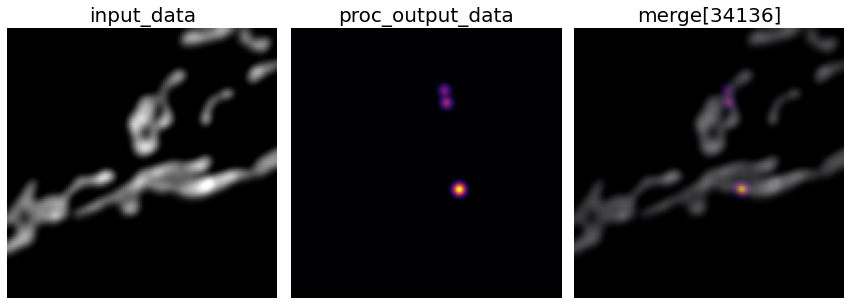

In [6]:
nb_examples = 2
#item_id = np.random.randint(low=0, high=output_data.shape[0]-1, size=nb_examples)
item_id = [34136]
labels = ['input_data', 'proc_output_data']
for input_img, output_img, frame in zip(input_data[item_id], proc_output_data[item_id], item_id):
  plot_comparison(input_img, output_img, frame=frame, merge=True, labels=labels)

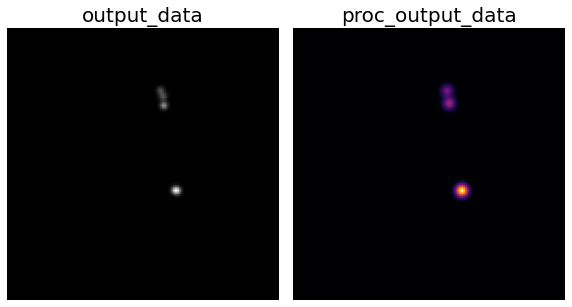

In [7]:
labels = ['output_data', 'proc_output_data']
for input_img, output_img, frame in zip(output_data[item_id], output_data[item_id], item_id):
  plot_comparison(input_img, prepareStack(output_img), labels=labels, frame=frame)

In [78]:
division_mask = proc_output_data!=0
binary_output = (np.any(np.any(division_mask, axis=1), axis=1))

#Active/inactive percentages in binary_output
print('Active: %.2f%%\nInactive: %.2f%%'%activity_percent(binary_output))

Active: 64.88%
Inactive: 35.12%


In [79]:
nb_img = input_data.shape[0]
mean_output_data = np.zeros(nb_img)
for frame in tqdm(np.where(binary_output)[0]):
  mean_output_data[frame] = np.mean(proc_output_data[frame])
  
mean_output_threshold = filters.threshold_multiotsu(mean_output_data, classes=3)[1]
binary_output = mean_output_data>mean_output_threshold

  0%|          | 0/24004 [00:00<?, ?it/s]

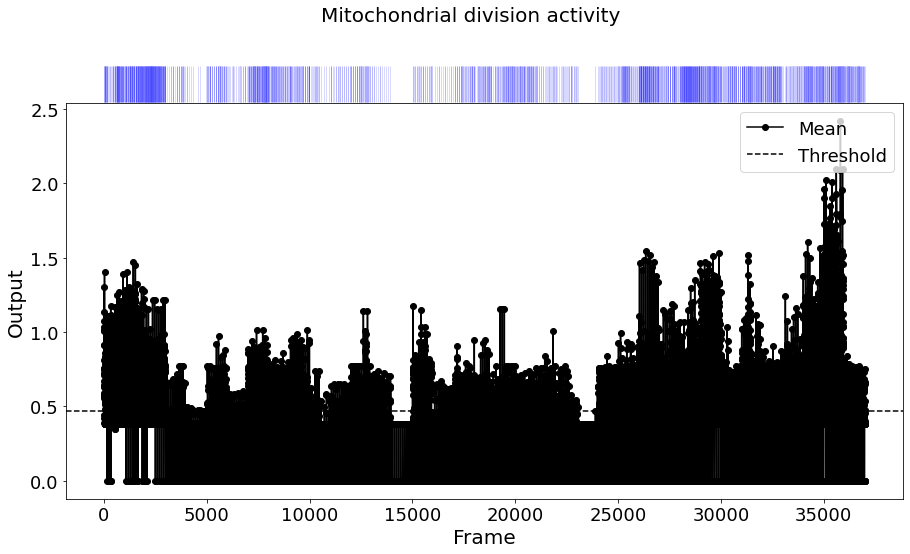

In [90]:
frames = np.arange(binary_output.shape[0])

fig = plt.figure(figsize=(15,8))
fig.suptitle('Mitochondrial division activity', size=20)

gs = fig.add_gridspec(2, 1, height_ratios=[1, 10], hspace=0)
ax_mean = fig.add_subplot(gs[1])
ax_binary = fig.add_subplot(gs[0], sharex=ax_mean)

#GT mean signal and temporal median filtering
ax_mean.plot(frames, mean_output_data[frames], 'o-', color='black', label='Mean')
ax_mean.axhline(mean_output_threshold, ls='--', color='black', label='Threshold')
ax_mean.set(xlabel='Frame', ylabel='Output')
ax_mean.legend(loc='upper right')

#Derived mitochondrial division activity by thresholding
ax_binary.fill_between(frames, 0, 1, where=binary_output[frames], color='blue', alpha=0.15)

ax_binary.axis('off')  

plt.show()

In [91]:
window_size = 7
filtered_mean_output = ndi.median_filter(mean_output_data, size=window_size)

mean_output_threshold = 0.47#filters.threshold_multiotsu(filtered_mean_output, classes=3)[1]
print('Threshold: %.3f'%mean_output_threshold)
binary_output = mean_output_data>mean_output_threshold
filtered_binary_output = filtered_mean_output>mean_output_threshold

#Active/inactive percentages in filtered_binary_output
print('\nWithout temporal median filter')
print('Active: %.2f%%\nInactive: %.2f%%'%activity_percent(binary_output))
print('\nWith temporal median filter')
print('Active: %.2f%%\nInactive: %.2f%%'%activity_percent(filtered_binary_output))

Threshold: 0.470

Without temporal median filter
Active: 21.79%
Inactive: 78.21%

With temporal median filter
Active: 20.42%
Inactive: 79.58%


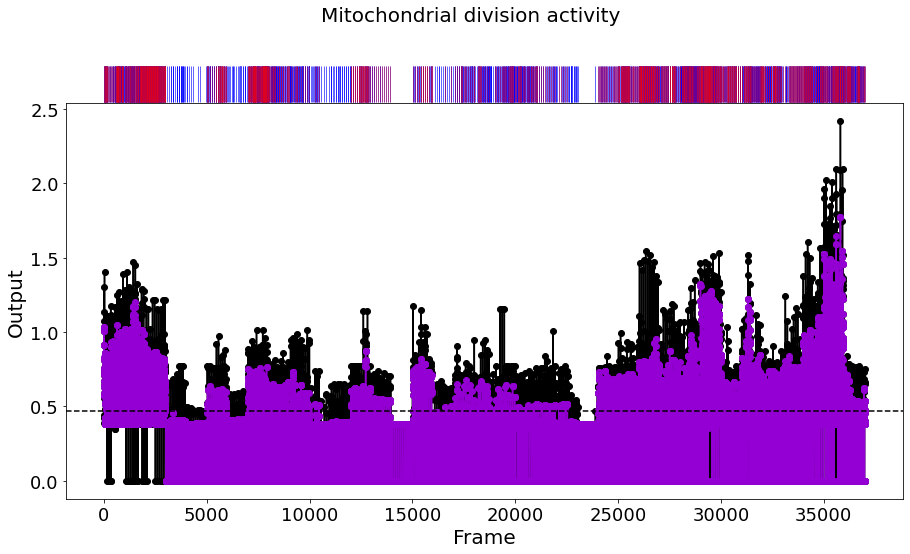

In [92]:
fig = plt.figure(figsize=(15,8))
fig.suptitle('Mitochondrial division activity', size=20)

gs = fig.add_gridspec(2, 1, height_ratios=[1, 10], hspace=0)
ax_mean = fig.add_subplot(gs[1])
ax_binary = fig.add_subplot(gs[0], sharex=ax_mean)

#GT mean signal and temporal median filtering
ax_mean.plot(frames, mean_output_data[frames], 'o-', color='black', label='Mean')
ax_mean.plot(frames, filtered_mean_output[frames], 'o-', color='darkviolet', label='Temporal median filter\nWindow size: %i'%window_size)
ax_mean.axhline(mean_output_threshold, ls='--', color='black', label='Threshold=%.1f'%mean_output_threshold)
ax_mean.set(xlabel='Frame', ylabel='Output')
#ax_mean.legend(loc='lower right')

#Derived mitochondrial division activity by thresholding

ax_binary.fill_between(frames, 0, 1, where=binary_output[frames], color='blue', alpha=0.6)
ax_binary.fill_between(frames, 0, 1, where=filtered_binary_output[frames], color='red', alpha=0.4)

ax_binary.axis('off')
plt.show()

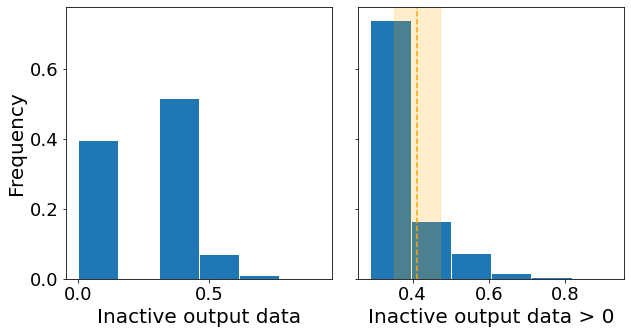

In [71]:
inactive_output_data = filtered_mean_output[binary_output==False]
nonzero_inactive_output_data = filtered_mean_output[(binary_output==False)&(filtered_mean_output>0)]

nbins = 7

xlabel=['Inactive output data', 'Inactive output data > 0']
ylabel=['Frequency', None]
fig, axes = plt.subplots(1, 2, figsize=(5*2, 5), sharey=True)

for inactive_data, xlab, ylab, ax in zip([inactive_output_data, nonzero_inactive_output_data], xlabel, ylabel, axes):
  inactive_output_bins = np.linspace(inactive_data.min(), inactive_data.max(), nbins, endpoint=True)
  inactive_output_bincenters, inactive_output_hist = norm_histogram(inactive_output_bins, inactive_data)[:2]
  binwidth= np.diff(inactive_output_bins)
  plot_histogram(inactive_output_bincenters, binwidth*inactive_output_hist, xlabel=xlab, ylabel=ylab, ax=ax)

inactive_mean, inactive_std = nonzero_inactive_output_data.mean(), nonzero_inactive_output_data.std()
axes[1].axvline(inactive_mean, ls='--', color='orange')
axes[1].axvspan(inactive_mean-inactive_std, inactive_mean+inactive_std, color='orange', alpha=0.2)
plt.subplots_adjust(wspace=0.1)
plt.show()

In [72]:
window_size = np.arange(2, 100)
nonzero_inactivity_max = np.zeros_like(window_size, dtype=float)
nonzero_inactivity_mean = np.zeros_like(window_size, dtype=float)
nonzero_inactivity_std = np.zeros_like(window_size, dtype=float)

for i, size in enumerate(window_size):
  filtered_mean_output = ndi.median_filter(mean_output_data, size=size)
  nonzero_inactive_output_data = filtered_mean_output[(mean_output_data==0)&(filtered_mean_output>0)]
  nonzero_inactivity_max[i] = nonzero_inactive_output_data.max()
  nonzero_inactivity_mean[i] = nonzero_inactive_output_data.mean()
  nonzero_inactivity_std[i] = nonzero_inactive_output_data.std()

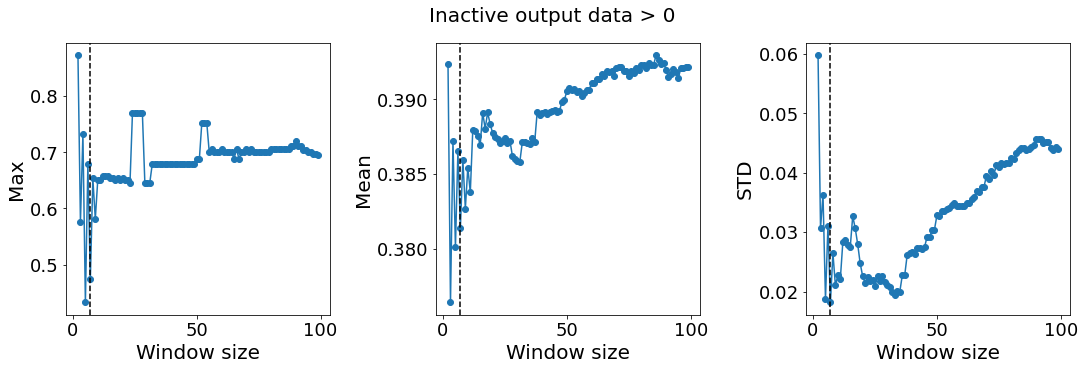

In [73]:
labels = ['Max', 'Mean', 'STD']
optimal_id = nonzero_inactivity_std==nonzero_inactivity_std.min()
optimal_window_size = window_size[optimal_id][0]
fig, axes = plt.subplots(1, 3, figsize=(6*3, 5), sharex=True)
fig.suptitle('Inactive output data > 0', size=20)
for stat, xlabel, ax in zip([nonzero_inactivity_max, nonzero_inactivity_mean, nonzero_inactivity_std], 
                            labels, axes):
  ax.plot(window_size, stat, 'o-')
  ax.set(xlabel='Window size', ylabel=xlabel)
  ax.axvline(optimal_window_size, ls='--', color='black')
fig.subplots_adjust(wspace=0.4)
plt.show()

In [33]:
def true_sequence_length(bits):
  # make sure all runs of ones are well-bounded
  bounded = np.hstack(([0], bits, [0]))
  # get 1 at run starts and -1 at run ends
  difs = np.diff(bounded)
  run_starts = np.where(difs > 0)[0]
  run_ends = np.where(difs < 0)[0]
  return run_ends - run_starts

In [ ]:
item_id_y = [205, 230, 305, 330]
item_id_n = [215, 260, 315, 340]
fig = plt.figure(figsize=(5*4, 5*2))              

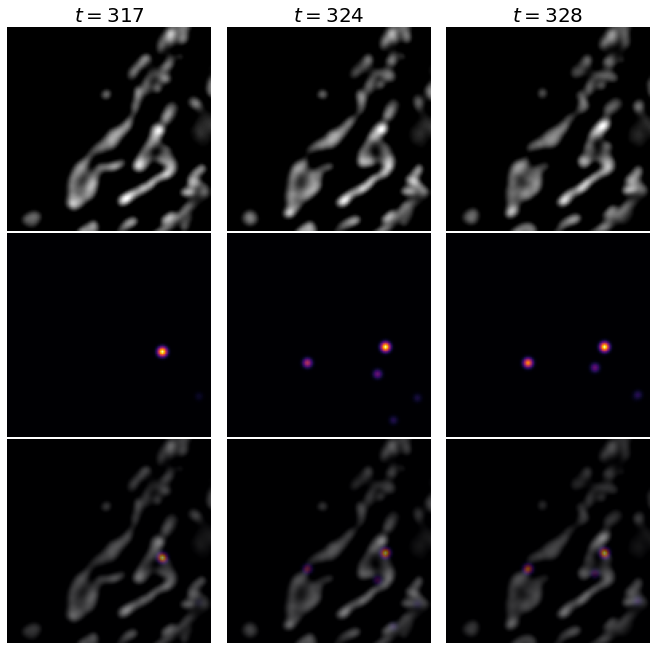

In [30]:
nb_examples = 3
item_id = [317, 324, 328]
size = nb_examples*3
fig, axes = plt.subplots(nb_examples, nb_examples, figsize=(size, size))
for i, frame in enumerate(item_id):
  plot_comparison(input_data[frame], proc_output_data[frame], merge=True, axes=axes[:, i])
  axes[0, i].set_title('$t=%i$'%frame, size=20)
  axes[1, i].set_title('')
  axes[2, i].set_title('')

fig.subplots_adjust(left=0, right=1, top=0.96, bottom=0.01, wspace=0.05, hspace=0.01)
plt.show()
#fig.savefig(new_data_path+'division_example.pdf')

H:/Santi/Figures/ground_truth_t34136.pdf


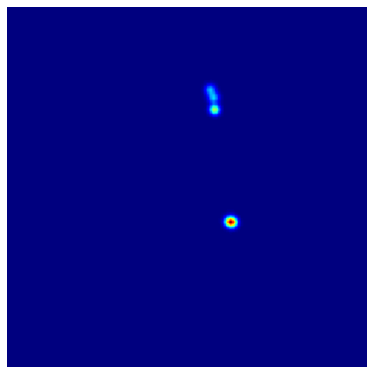

In [202]:
item_id = 34136
cmap = 'jet'
title = 'ground_truth'
title = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(title)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(output_data[item_id], cmap=cmap)
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()
#plt.savefig(title)

H:/Santi/Figures/distance_map_t34136.pdf


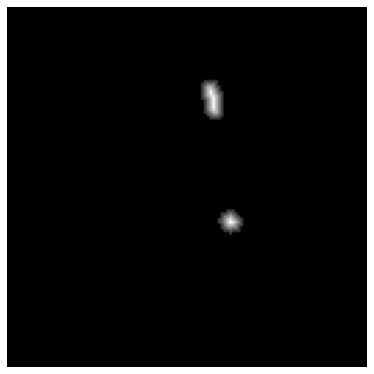

In [203]:
cmap = 'gray'
title = 'distance_map'
title = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(title)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(ndi.distance_transform_edt(output_data[item_id]), cmap=cmap)
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()
#plt.savefig(title)

H:/Santi/Figures/watershed_t34136.pdf


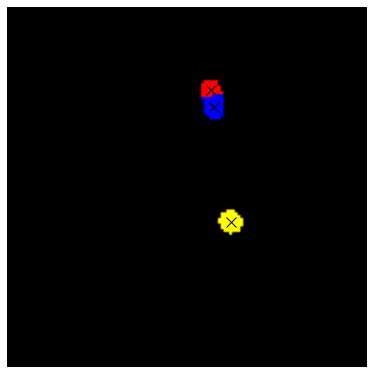

In [237]:
labels = distance_watershed(output_data[item_id])
rp = measure.regionprops(labels)
centroids = np.array([region.centroid for region in rp]).round().astype(int)

title = 'watershed'
title = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(title)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(label2rgb(labels, bg_label=0))
ax.plot(centroids[:, 1], centroids[:, 0], 'x', markersize=10, color='black')
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()
#plt.savefig(title)

H:/Santi/Figures/proc_ground_truth_t34136.pdf


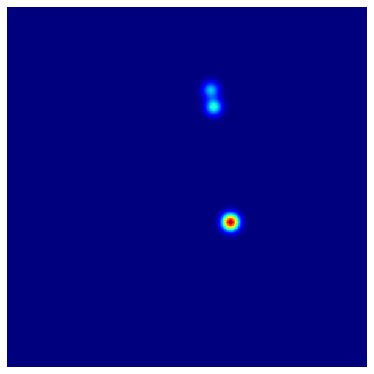

In [205]:
cmap='jet'
title = 'proc_ground_truth'
title = base_dir+'Figures/'+title+'_t{:05}.pdf'.format(item_id)
print(title)

fig, ax = plt.subplots(figsize=(5, 5))
ax.imshow(proc_output_data[item_id], cmap=cmap)
ax.axis('off')
plt.tight_layout(pad=0)
plt.show()
#plt.savefig(title)